# Intern Project - Predict the temperature of permanent magnet

## Problem Statement:

Prolonged usage of PMSMs (Permanent Magnet Synchronous Motor) are causing overheating of the permanent magnet leading to various other problems stemming from this over heating. On the rotor part, irreversible demagnetization of the permanent magnets can be caused by overheating, which represents an even more severe instance of motor damage. We need to somehow stop this temperature increase from overshooting.

### Inspiration

The most interesting target features are rotor temperature ("pm"), stator temperatures ("stator_*") and torque.
Especially rotor temperature and torque are not reliably and economically measurable in a commercial vehicle.

Being able to have strong estimators for the rotor temperature helps the automotive industry to manufacture motors with less material and enables control strategies to utilize the motor to its maximum capability.
A precise torque estimate leads to more accurate and adequate control of the motor, reducing power losses and eventually heat build-up.

## Approach taken:

One possible way to monitor this increase in temperature of the permanent magnet is by  using temperature sensors to measure temperature of the permanent magnet at various time stamps.
But instead of jumping into the brute force solution, let's look at Machine Learning and Deep Learning advancements if we can train a model that can predict the temperature with the help of other factors involved in the process of running a PMSM.

To train a model using ML techniques we need:

1. Perform experiments and collect all relevant data.
2. Process the data and look for missing values, outliers,..
3. Look at the nature of the data using data visualization techniques
4. Then perform feature engineering on the dataset to generate meaningful features which will help later in prediction.
5. Arrive at a suitable architecture to train the model.
6. If there are more than one algorithm which might work better, train the model using the algorithms and look at the evaluation metrics to arrive at the best model.

## Basic Pipeline

1. Data Collection
2. Data Analysis : EDA (Exploratory Data Analysis)
3. Data Preprocessing: Data Cleaning, Feature Encoding, Feature Engineering,  Train-Validation-Test split, Feature Scaling
4. Model Selection and training: Use performance metrics to choose the best architecture and train.
5. Model Validation
6. Model Registry and Serving
7. Model Performance monitoring

## Data Collection

There was a pre-existing Kaggle dataset

https://www.kaggle.com/datasets/wkirgsn/electric-motor-temperature

In [1]:
#importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r"C:\Users\asugumar\Desktop\measures_v2.csv")
df.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,0.187101,17
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,0.245417,17
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,0.176615,17
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,0.238303,17
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,0.208197,17


### About the dataset

1. All recordings are sampled at 2 Hz.
2. The data set consists of multiple measurement sessions, which can be distinguished from each other by column "profile_id".
3. A measurement session can be between one and six hours long.

Columns of the data set represents:

1. u_q = Voltage q-component measurement in dq-coordinates (in V)
2. coolant = Coolant temperature (in °C)
3. stator_winding = Stator winding temperature (in °C) measured with thermocouples
4. u_d = Voltage d-component measurement in dq-coordinates
5. stator_tooth = Stator tooth temperature (in °C) measured with thermocouples
6. motor_speed = Motor speed (in rpm)
7. i_d = Current d-component measurement in dq-coordinates
8. i_q = Current q-component measurement in dq-coordinates
9. pm = Permanent magnet temperature (in °C) measured with thermocouples and transmitted wirelessly
10. stator_yoke = Stator yoke temperature (in °C) measured with thermocouples
11. ambient = Ambient temperature (in °C)
12. torque = Motor torque (in Nm)
13. profile_id = Measurement session id. Each distinct measurement session can be identified through this integer id.

## Data Analysis

In [3]:
df.shape

(1330816, 13)

In [4]:
df.describe()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
count,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06
mean,5.427900e+01,3.622999e+01,6.634275e+01,-2.513381e+01,5.687858e+01,2.202081e+03,-6.871681e+01,3.741278e+01,5.850678e+01,4.818796e+01,2.456526e+01,3.110603e+01,4.079306e+01
std,4.417323e+01,2.178615e+01,2.867206e+01,6.309197e+01,2.295223e+01,1.859663e+03,6.493323e+01,9.218188e+01,1.900150e+01,1.999100e+01,1.929522e+00,7.713575e+01,2.504549e+01
min,-2.529093e+01,1.062375e+01,1.858582e+01,-1.315304e+02,1.813398e+01,-2.755491e+02,-2.780036e+02,-2.934268e+02,2.085696e+01,1.807669e+01,8.783478e+00,-2.464667e+02,2.000000e+00
25%,1.206992e+01,1.869814e+01,4.278796e+01,-7.869090e+01,3.841601e+01,3.171107e+02,-1.154061e+02,1.095863e+00,4.315158e+01,3.199033e+01,2.318480e+01,-1.374265e-01,1.700000e+01
50%,4.893818e+01,2.690014e+01,6.511013e+01,-7.429755e+00,5.603635e+01,1.999977e+03,-5.109376e+01,1.577401e+01,6.026629e+01,4.562551e+01,2.479733e+01,1.086035e+01,4.300000e+01
75%,9.003439e+01,4.985749e+01,8.814114e+01,1.470271e+00,7.558668e+01,3.760639e+03,-2.979688e+00,1.006121e+02,7.200837e+01,6.146083e+01,2.621702e+01,9.159718e+01,6.500000e+01
max,1.330370e+02,1.015985e+02,1.413629e+02,1.314698e+02,1.119464e+02,6.000015e+03,5.189670e-02,3.017079e+02,1.136066e+02,1.011480e+02,3.071420e+01,2.610057e+02,8.100000e+01


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330816 entries, 0 to 1330815
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   u_q             1330816 non-null  float64
 1   coolant         1330816 non-null  float64
 2   stator_winding  1330816 non-null  float64
 3   u_d             1330816 non-null  float64
 4   stator_tooth    1330816 non-null  float64
 5   motor_speed     1330816 non-null  float64
 6   i_d             1330816 non-null  float64
 7   i_q             1330816 non-null  float64
 8   pm              1330816 non-null  float64
 9   stator_yoke     1330816 non-null  float64
 10  ambient         1330816 non-null  float64
 11  torque          1330816 non-null  float64
 12  profile_id      1330816 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 132.0 MB


In [6]:
df.isnull().sum()

u_q               0
coolant           0
stator_winding    0
u_d               0
stator_tooth      0
motor_speed       0
i_d               0
i_q               0
pm                0
stator_yoke       0
ambient           0
torque            0
profile_id        0
dtype: int64

### Measurement session lengths

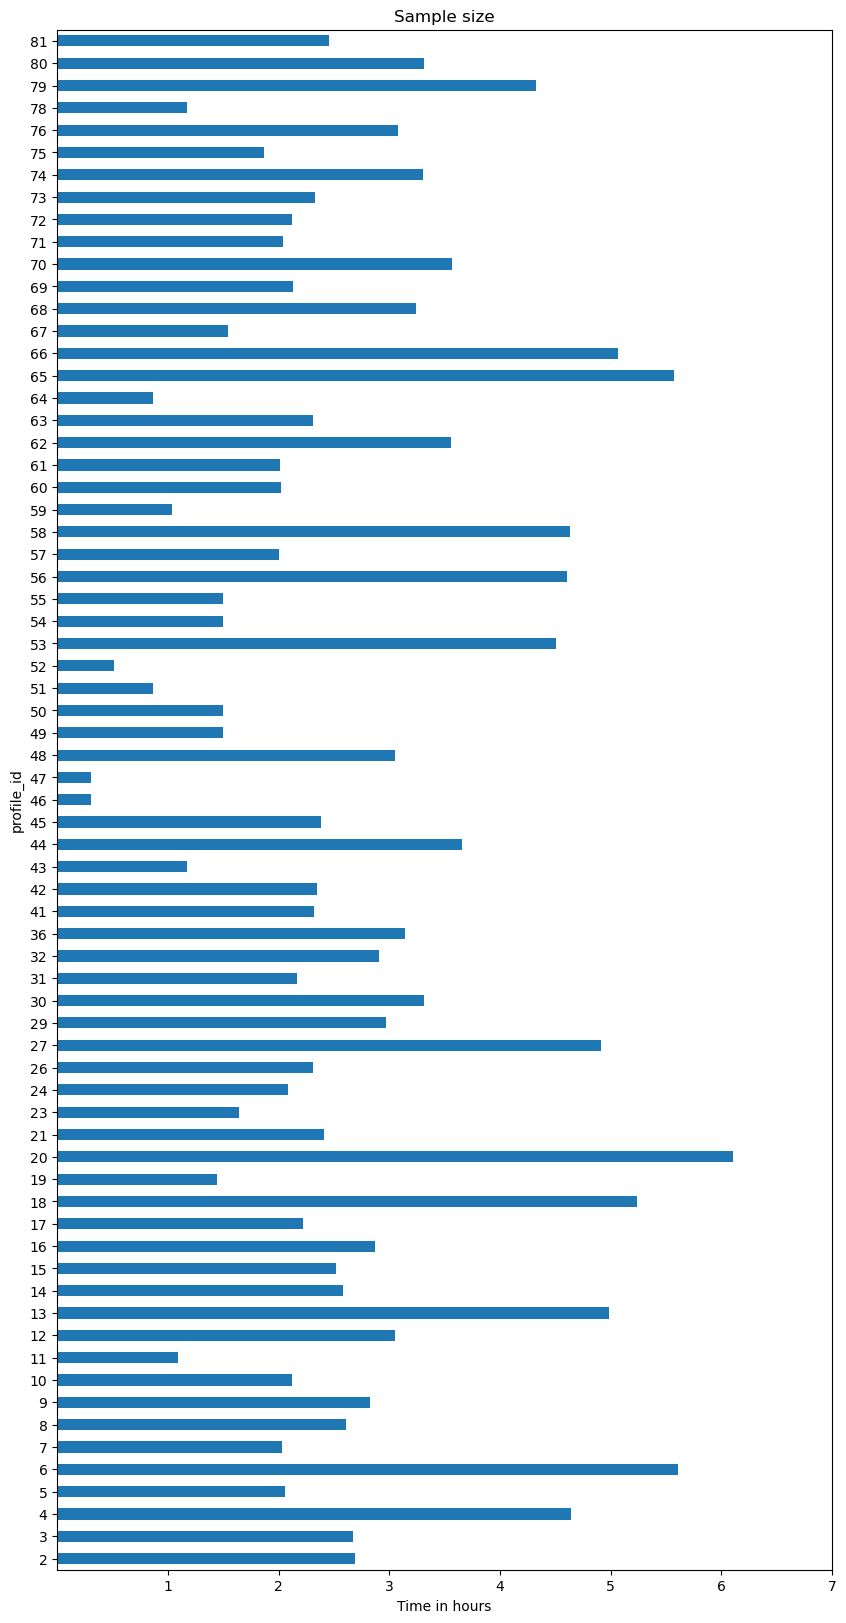

In [7]:
p_counts = df.groupby('profile_id')['pm'].agg('count')
ax = p_counts.plot.barh(figsize=(10, 20), title='Sample size')
_ = ax.set_xticks(2*3600*np.arange(1, 8)) # 2Hz sample rate
_ = ax.set_xticklabels(list(range(1, 8)))
_ = ax.set_xlabel('Time in hours')

The plots below show that all measurement sessions range from 20 minutes to around 6 hours. The two short session ids "46" and "47" might be not very representative as temperatures inside electric motors need time to vary.

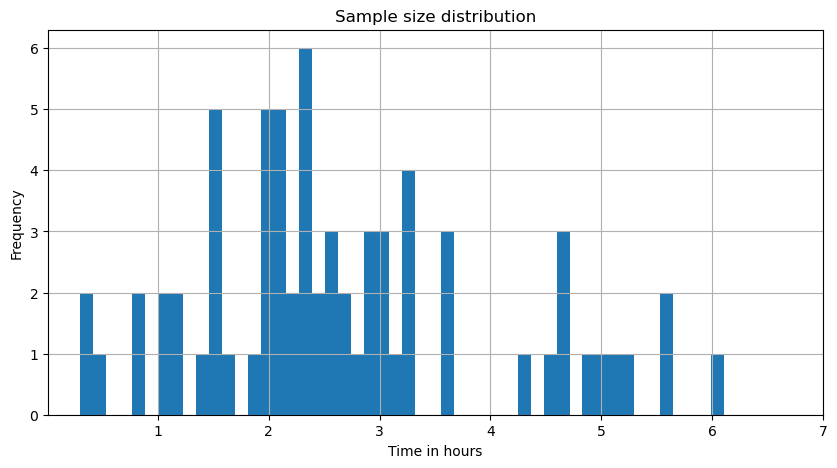

In [8]:
ax = p_counts.plot.hist(title='Sample size distribution', bins=50, figsize=(10, 5), grid=True)
_ = ax.set_xticks(2*3600*np.arange(1, 8)) # 2Hz sample rate
_ = ax.set_xticklabels(list(range(1, 8)))
_ = ax.set_xlabel('Time in hours')

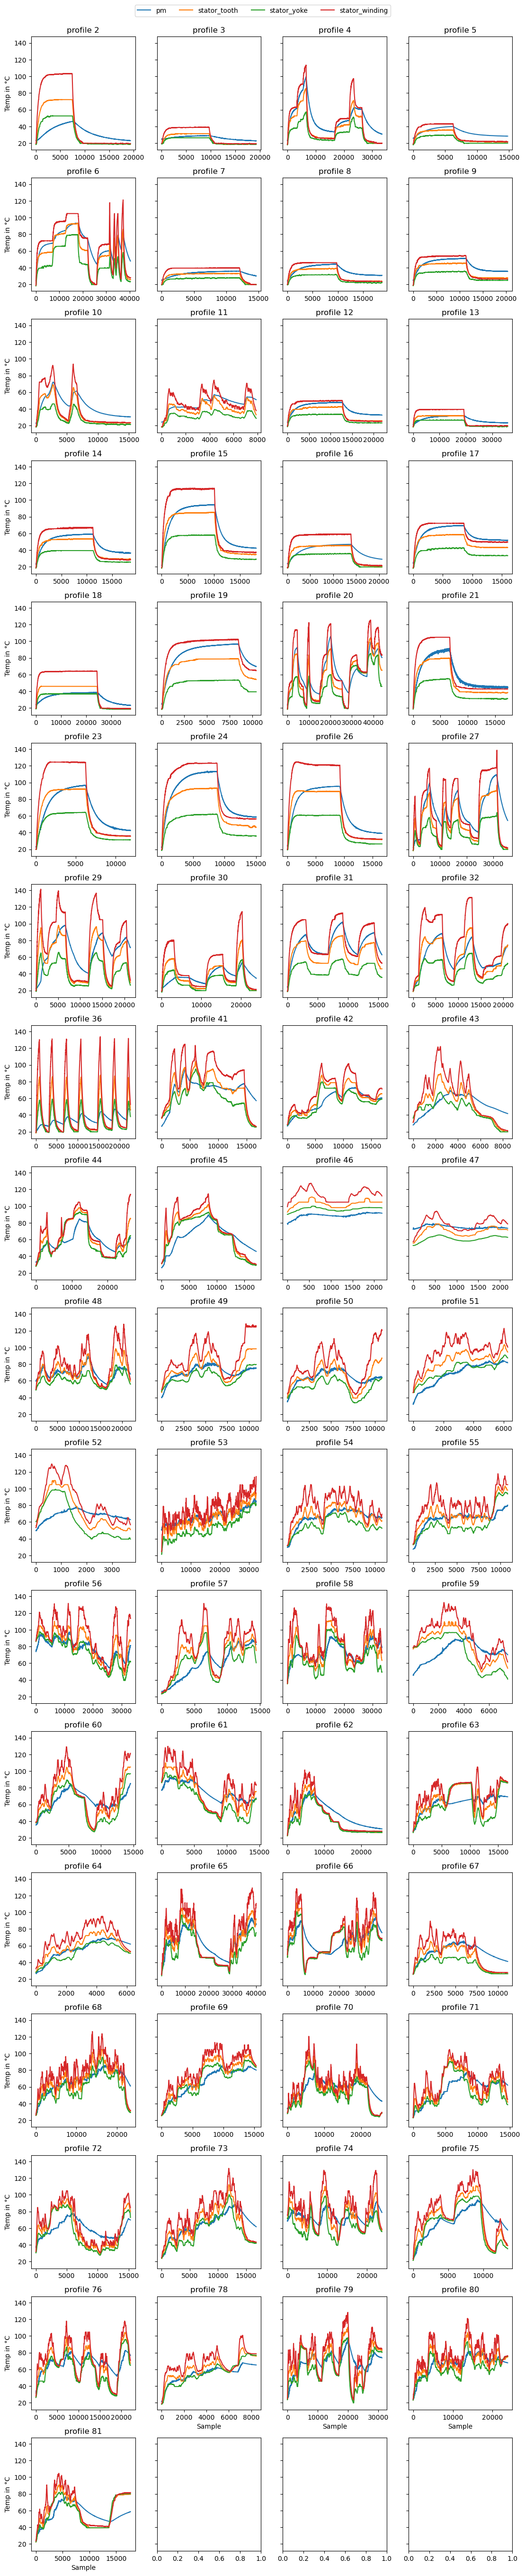

In [9]:
grpd = {pid: df_ for pid, df_ in df.groupby('profile_id')}
coi = ['pm', 'stator_tooth', 'stator_yoke', 'stator_winding']
n_cols = 4
n_rows = np.ceil(len(grpd) / n_cols).astype(int)
fig, axes = plt.subplots(n_rows, n_cols, sharey=True, figsize=(2.8*n_cols, n_rows*3))
for i, (ax, (p_id, df_)) in enumerate(zip(axes.flatten(), grpd.items())):
    for c in coi:
        lines = ax.plot(df_[c].reset_index(drop=True), label=c)
    ax.set_title(f'profile {p_id}')
    if i % n_cols == 0:
        ax.set_ylabel('Temp in °C')
    if i >= (len(grpd) - n_cols):
        ax.set_xlabel('Sample')
fig.tight_layout()
_ = ax.legend(ncol=15, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure)

Here, profile_id 4 seems to be the closest observation to the real world case. Let's shift our focus to the single profile_id 4.

Let's create a seperate dataframe with only the data of profile_id = 4

In [43]:
df_id4 = df.loc[df['profile_id'] == 4]
df_id4.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
110332,-0.876308,17.558941,18.636782,1.191286,18.133976,0.003842,-1.973073,1.083640,22.959057,18.201054,23.646744,0.435272,4
110333,-0.868898,17.590738,18.647318,1.307029,18.161402,0.002049,-1.977168,1.086277,22.953550,18.209829,23.610411,0.518918,4
110334,-1.048028,17.598307,18.654879,1.514929,18.178177,0.004504,-1.981125,1.087644,22.949497,18.220852,23.588314,0.495170,4
110335,-1.049341,17.596458,18.647297,1.577056,18.198172,0.000367,-1.761789,0.979492,22.965916,18.222155,23.592031,0.558552,4
110336,-1.104186,17.596216,18.633831,1.677850,18.205481,0.003372,-1.828795,1.012324,22.961769,18.218958,23.605129,0.553410,4


In [44]:
df_id4 = df_id4.drop(columns=['profile_id'])

In [45]:
df_id4.shape

(33424, 12)

### Linear Correlations

<Axes: >

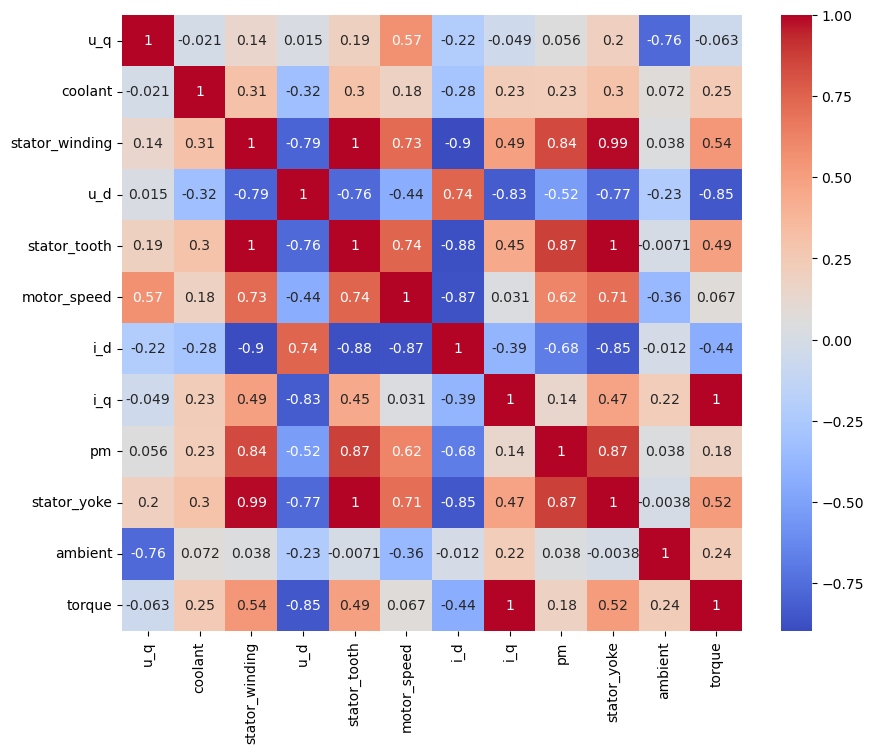

In [13]:
corr = df_id4.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')

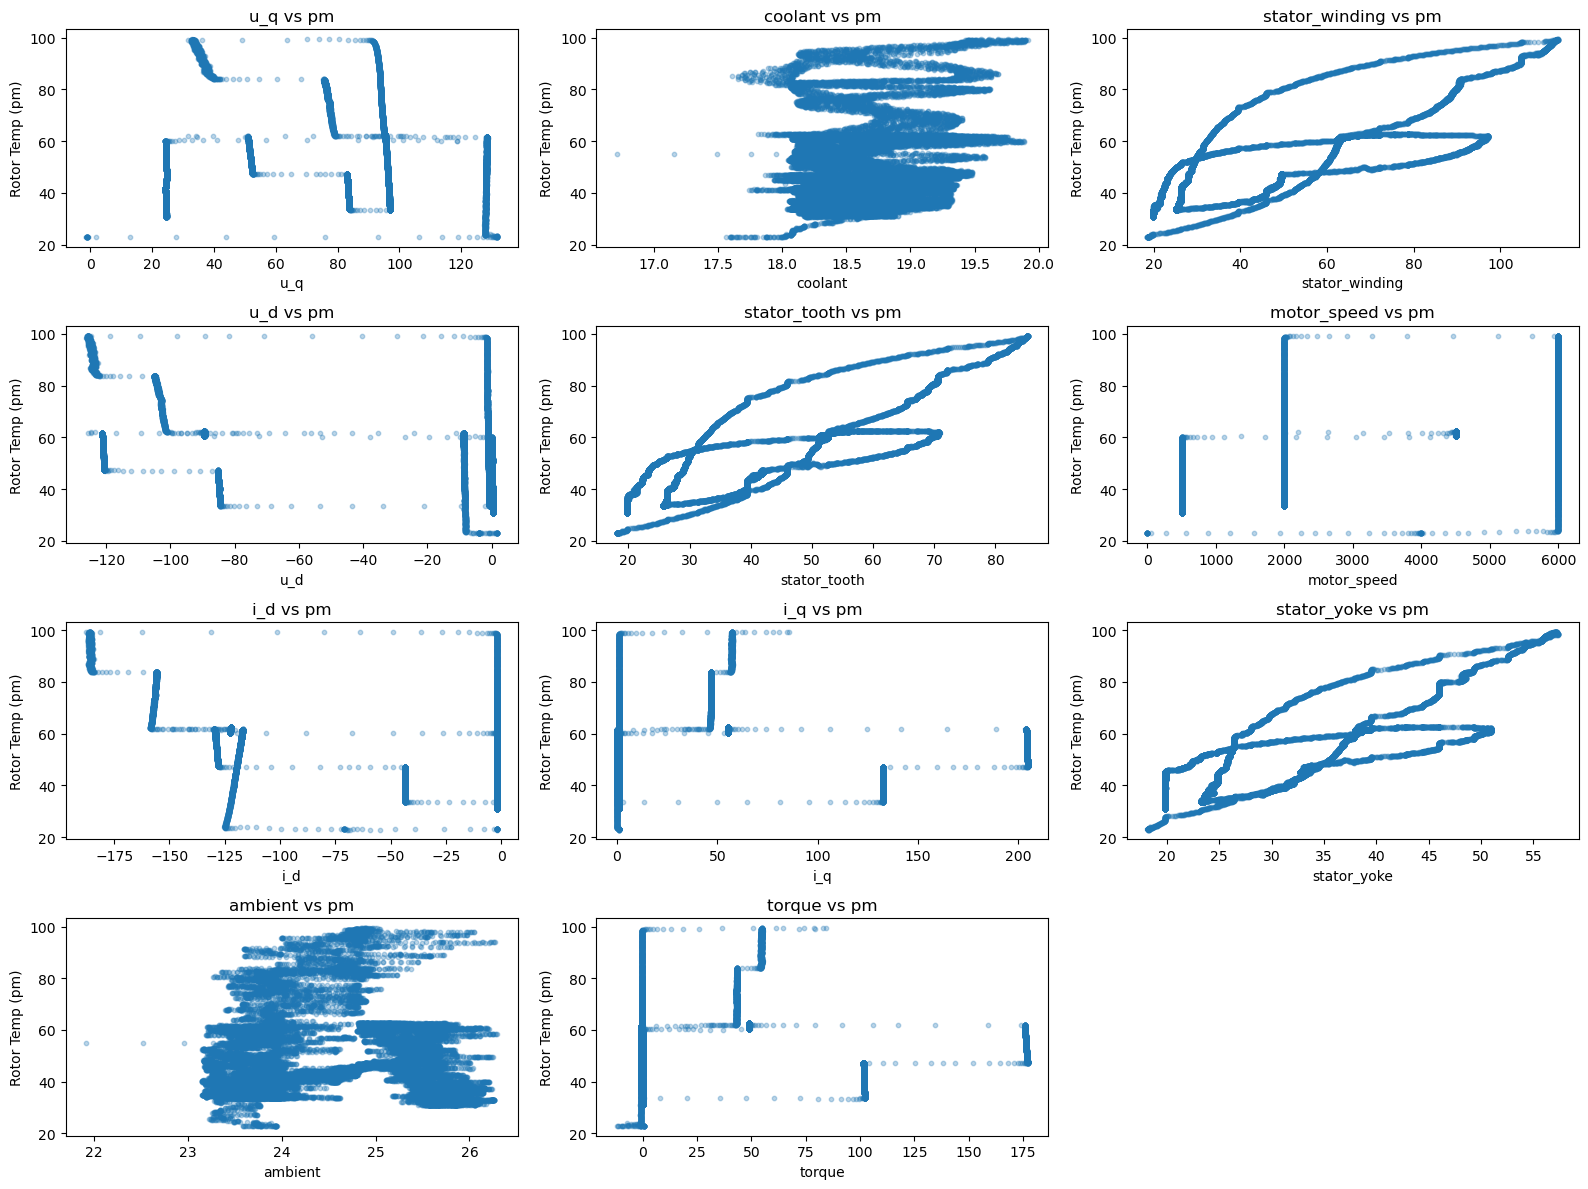

In [14]:
Columns = ['u_q', 'coolant', 'stator_winding', 'u_d', 'stator_tooth',
           'motor_speed', 'i_d', 'i_q', 'stator_yoke', 'ambient', 'torque']

num_cols = len(Columns)
cols_per_row = 3
rows = (num_cols + cols_per_row - 1) // cols_per_row  # Ceiling division

fig, axes = plt.subplots(rows, cols_per_row, figsize=(16, 3 * rows))
axes = axes.flatten()  # Flatten in case of single row

for i, col in enumerate(Columns):
    ax = axes[i]
    ax.scatter(df_id4[col], df_id4['pm'], alpha=0.3, s=10)
    ax.set_xlabel(col)
    ax.set_ylabel('Rotor Temp (pm)')
    ax.set_title(f'{col} vs pm')

# Hide any unused subplots
for i in range(num_cols, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

From both correlation map and the variation of each column with pm, we see that a few of the columns are internalyy correlated to each other. if we ignore this internal correlation and build the model using these features, the model will learn the unwanted weghtage for certain columns which will badly influence the model performance. Let us use PCA (Principal Component Analysis) to reduce the dimension.

## Flow of implementation

1. Time-series nature of the data: Since the dataset has time-series nature in it, we need to keep this important information in mind while building the model.

2. Multi collinearity: When computed the correlation between all the columns of the given data, there existed strong correlation between features. If all the columns are directly taken as features to build the model, we will face a very big issue of “Dimension Curse”. We can apply PCA to reduce the dimension of the dataset without losing much information from it.

3. Feature scaling: Another important factor to keep in mind is the irregular range of values of various columns. This will create an internal bias in the weightage of features used to make predictions. Before using the data to train, we need to convert all the features to a single scale to prevent unwanted, internal bias.  

4. Cross validation: I have divided the dataset into training data (60%), validation data (20%), test data (20%); keeping in mind the time-series nature of the data. Here the training data is used to train the model and adjust parameters inside the training. Then the validation set is used to tune the hyper parameters of the model. Later the model’s performance is tested on the fresh; untouched test set and the performance metrics are derived using the test set. Important note here is to scale the train, validation, test sets separately after their division in order to ensure that the model has no future data leakage into it while being trained.

5. Hyperparameter tuning: The method that’s used here to train the hyperparameters is GridSearchCV. 


In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

#STEP 1: Chronological Split (already sorted by time)
n = len(df_id4)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

train_df = df_id4.iloc[:train_end]
val_df = df_id4.iloc[train_end:val_end]
test_df = df_id4.iloc[val_end:]

X_train = train_df.drop('pm', axis=1)
y_train = train_df['pm']
X_val = val_df.drop('pm', axis=1)
y_val = val_df['pm']
X_test = test_df.drop('pm', axis=1)
y_test = test_df['pm']

In [16]:
#STEP 2: Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


=== PCA with 95% variance retained ===
Reduced from 11 to 5 features
Ridge | Val RMSE: 9.9984 | Test RMSE: 30.2227 | Test R²: -17.4491


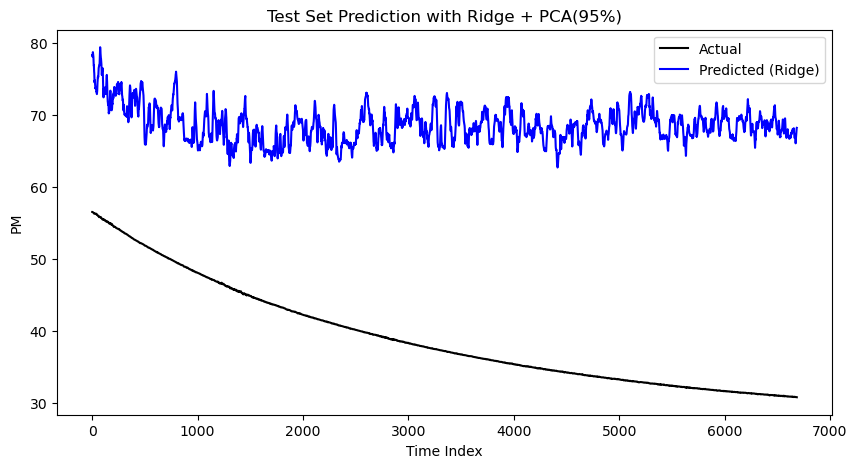

Lasso | Val RMSE: 9.9609 | Test RMSE: 30.1618 | Test R²: -17.3748


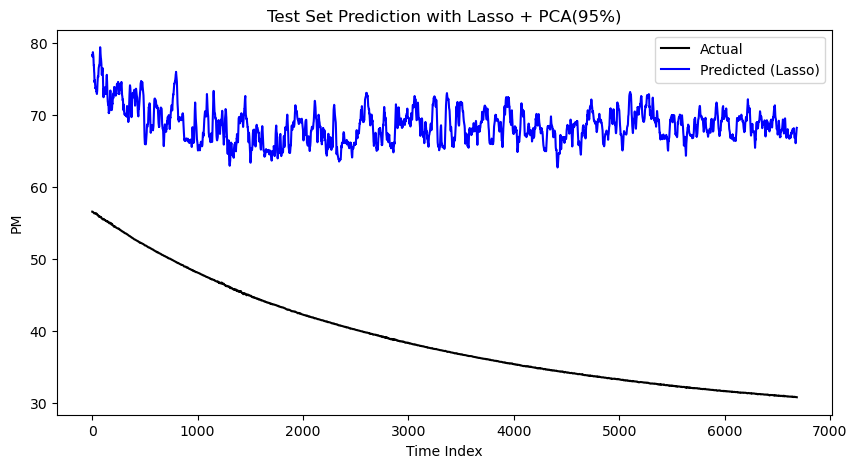


=== PCA with 99% variance retained ===
Reduced from 11 to 6 features
Ridge | Val RMSE: 8.8658 | Test RMSE: 5.9980 | Test R²: 0.2734


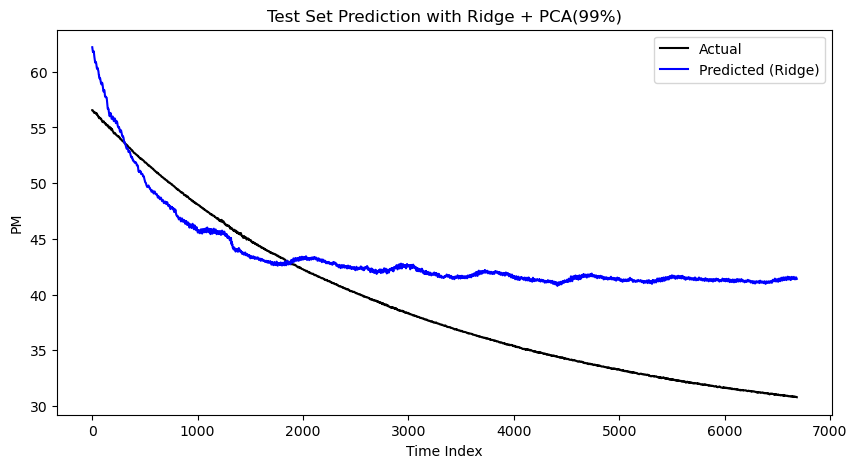

Lasso | Val RMSE: 8.8470 | Test RMSE: 6.0290 | Test R²: 0.2658


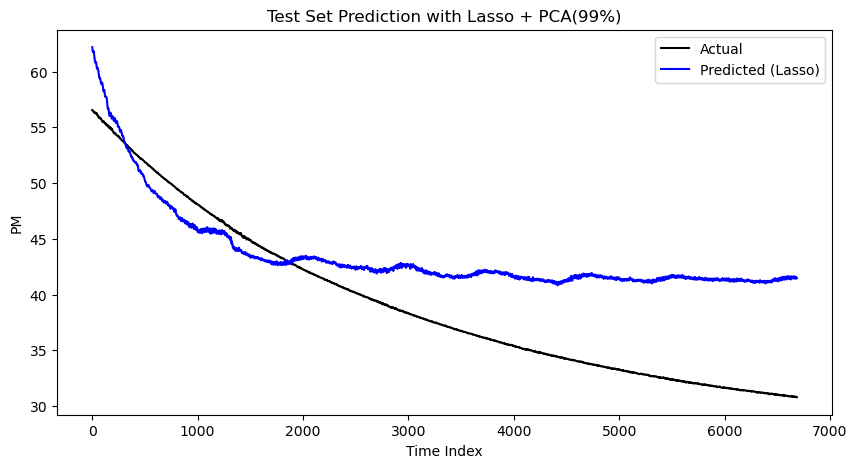

In [17]:
#STEP 3: Try with PCA thresholds: 0.95, 0.99
for pca_thresh in [0.95, 0.99]:
    print(f"\n=== PCA with {int(pca_thresh*100)}% variance retained ===")

    pca = PCA(n_components=pca_thresh)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_pca = pca.transform(X_val_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    print(f"Reduced from {X_train.shape[1]} to {X_train_pca.shape[1]} features")

    #Try both Ridge and Lasso
    for model_name, model in {
        "Ridge": Ridge(alpha=2.0),
        "Lasso": Lasso(alpha=0.01, max_iter=10000)
    }.items():
        model.fit(X_train_pca, y_train)

        y_pred_val = model.predict(X_val_pca)
        y_pred_test = model.predict(X_test_pca)

        val_rmse = mean_squared_error(y_val, y_pred_val, squared=False)
        test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
        test_r2 = r2_score(y_test, y_pred_test)

        print(f"{model_name} | Val RMSE: {val_rmse:.4f} | Test RMSE: {test_rmse:.4f} | Test R²: {test_r2:.4f}")

        if pca_thresh == 0.95 and model_name == "Ridge":
            plt.figure(figsize=(10, 5))
            plt.plot(y_test.values, label='Actual', color='black')
            plt.plot(y_pred_test, label='Predicted (Ridge)', color='blue')
            plt.title('Test Set Prediction with Ridge + PCA(95%)')
            plt.xlabel('Time Index')
            plt.ylabel('PM')
            plt.legend()
            plt.show()

        if pca_thresh == 0.95 and model_name == "Lasso":
            plt.figure(figsize=(10, 5))
            plt.plot(y_test.values, label='Actual', color='black')
            plt.plot(y_pred_test, label='Predicted (Lasso)', color='blue')
            plt.title('Test Set Prediction with Lasso + PCA(95%)')
            plt.xlabel('Time Index')
            plt.ylabel('PM')
            plt.legend()
            plt.show()

        if pca_thresh == 0.99 and model_name == "Ridge":
            plt.figure(figsize=(10, 5))
            plt.plot(y_test.values, label='Actual', color='black')
            plt.plot(y_pred_test, label='Predicted (Ridge)', color='blue')
            plt.title('Test Set Prediction with Ridge + PCA(99%)')
            plt.xlabel('Time Index')
            plt.ylabel('PM')
            plt.legend()
            plt.show()

        if pca_thresh == 0.99 and model_name == "Lasso":
            plt.figure(figsize=(10, 5))
            plt.plot(y_test.values, label='Actual', color='black')
            plt.plot(y_pred_test, label='Predicted (Lasso)', color='blue')
            plt.title('Test Set Prediction with Lasso + PCA(99%)')
            plt.xlabel('Time Index')
            plt.ylabel('PM')
            plt.legend()
            plt.show()

Let's seperate the n_components = 0.99 since it has the better prediction of all

In [18]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [19]:
#Step 1: Chronological Split (Assume df is already time-ordered)
n = len(df_id4)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

train_df = df_id4.iloc[:train_end]
val_df = df_id4.iloc[train_end:val_end]
test_df = df_id4.iloc[val_end:]

X_train = train_df.drop('pm', axis=1)
y_train = train_df['pm']
X_val = val_df.drop('pm', axis=1)
y_val = val_df['pm']
X_test = test_df.drop('pm', axis=1)
y_test = test_df['pm']

In [20]:
#Step 3: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [21]:
#Step 4: PCA (retain 99% variance)
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [22]:
#Step 5: Set up RMSE scorer and TimeSeriesSplit
rmse_scorer = make_scorer(mean_squared_error, squared=False)
tscv = TimeSeriesSplit(n_splits=5)

In [23]:
#Train final model on train+val and evaluate on test
best_lasso = Lasso(alpha= 0.01, max_iter=10000)
best_lasso.fit(X_train_pca, y_train)
y_val_pred = best_lasso.predict(X_val_pca)

val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
print(f" Validation RMSE: {val_rmse:.4f}")

 Validation RMSE: 8.8470


Final Test RMSE: 6.0290


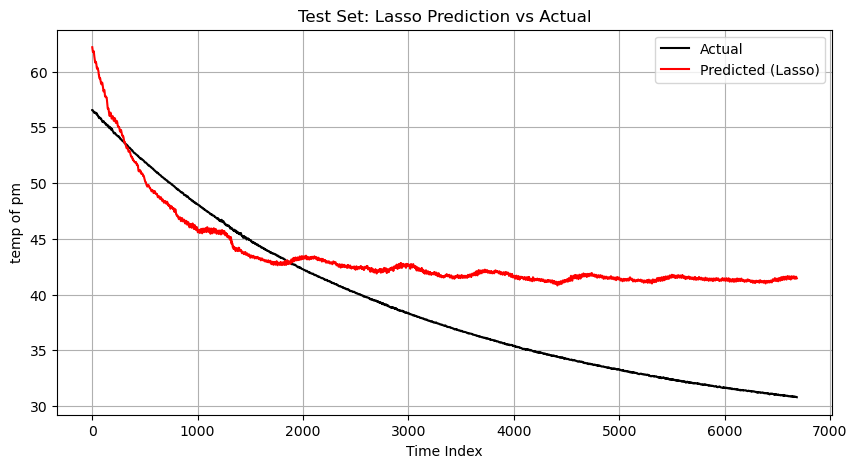

In [24]:
y_test_pred = best_lasso.predict(X_test_pca)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"Final Test RMSE: {test_rmse:.4f}")

#plot prediction vs actual on validation
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual', color='black')
plt.plot(y_test_pred, label='Predicted (Lasso)', color='red')
plt.title('Test Set: Lasso Prediction vs Actual')
plt.xlabel('Time Index')
plt.ylabel('temp of pm')
plt.legend()
plt.grid(True)
plt.show()

This project focused on building a robust regression pipeline for predicting the rotor temperature (pm) of an electric motor, using a time-series dataset. By carefully preserving temporal structure, avoiding data leakage, and applying principled preprocessing (scaling + PCA), we ensured both model accuracy and reliability.

Why Lasso Worked Best:
Among the various models experimented with, Lasso Regression outperformed others due to:

Its ability to handle multicollinearity (especially after PCA), Simplicity and interpretability,Natural tendency to prevent overfitting via L1 regularization.

## Deep Learning Implementation - Future Extension of the model

A recurrent neural network (RNN) is a special type of artificial neural network adapted to work for time series data or data that involves sequences.
Ordinary feedforward neural networks are only meant for data points that are independent of each other. However, if we have data in a sequence such that one data point depends upon the previous data point, we need to modify the neural network to incorporate the dependencies between these data points. 
RNNs have the concept of “memory” that helps them store the states or information of previous inputs to generate the next output of the sequence.

Why deep learning than the traditional ML model?
Deep learning has been there in existence for many decades now, but it has picked up rapidly in the past few years because of the following reasons:

1. Data - DL works better if the volume of data is huge. In recent years, data storage has evolved exponentially, thanks to cloud storage and the advancements in semiconductor technology.
2. Computation power - With the advancement of computational powers, thanks to GPUs, we are now able to perform computations in seconds which used to take days for computing.

Batch Learning:

The criterion used to classify Machine Learning systems is whether or not the system can learn incrementally from a stream of incoming data.
In batch learning, the system is incapable of learning incrementally: it must be trained using all the available data. This will generally take a lot of time and computing resources


# Neural Network Implementation - LSTM

To preserve the temporal order of the data, lets create a column called timestamp using the knowledge that we have. 

Profile ID 4 was 4.5 hours long and the sampling rate is 2Hz per sample.

<Axes: >

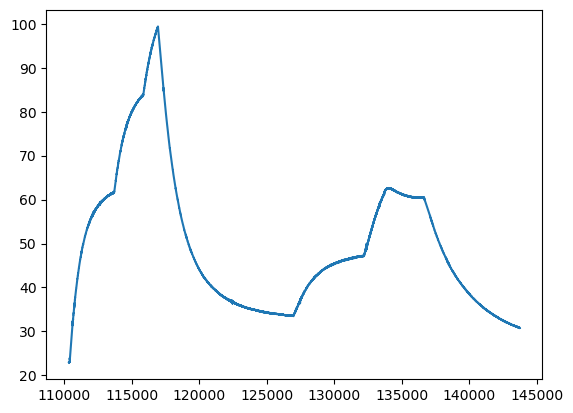

In [46]:
temp_bef = df_id4['pm']
temp_bef.plot()

In [47]:
# Starting reference time
start_time = pd.Timestamp('01-01-2025 00:00:00')

# Frequency = 0.5 seconds = 500 milliseconds → 2Hz
df_id4['timestamp'] = pd.date_range(start=start_time, periods=len(df_id4), freq='500ms')

In [48]:
df_id4.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,timestamp
110332,-0.876308,17.558941,18.636782,1.191286,18.133976,0.003842,-1.973073,1.083640,22.959057,18.201054,23.646744,0.435272,2025-01-01 00:00:00.000
110333,-0.868898,17.590738,18.647318,1.307029,18.161402,0.002049,-1.977168,1.086277,22.953550,18.209829,23.610411,0.518918,2025-01-01 00:00:00.500
110334,-1.048028,17.598307,18.654879,1.514929,18.178177,0.004504,-1.981125,1.087644,22.949497,18.220852,23.588314,0.495170,2025-01-01 00:00:01.000
110335,-1.049341,17.596458,18.647297,1.577056,18.198172,0.000367,-1.761789,0.979492,22.965916,18.222155,23.592031,0.558552,2025-01-01 00:00:01.500
110336,-1.104186,17.596216,18.633831,1.677850,18.205481,0.003372,-1.828795,1.012324,22.961769,18.218958,23.605129,0.553410,2025-01-01 00:00:02.000


In [49]:
df_id4 = df_id4[::4]
df_id4.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,timestamp
110332,-0.876308,17.558941,18.636782,1.191286,18.133976,0.003842,-1.973073,1.083640,22.959057,18.201054,23.646744,0.435272,2025-01-01 00:00:00
110336,-1.104186,17.596216,18.633831,1.677850,18.205481,0.003372,-1.828795,1.012324,22.961769,18.218958,23.605129,0.553410,2025-01-01 00:00:02
110340,-1.133303,17.706575,18.644501,1.657721,18.212990,-0.002288,-1.955065,1.072144,22.947355,18.198067,23.687092,0.626474,2025-01-01 00:00:04
110344,-1.221230,17.747663,18.648420,1.747121,18.219919,-0.006472,-1.989505,1.091273,22.956785,18.188841,23.736561,0.609166,2025-01-01 00:00:06
110348,-1.214958,17.651754,18.647293,1.724896,18.236738,0.000894,-1.996426,1.096065,22.955256,18.194143,23.897657,0.618519,2025-01-01 00:00:08


In [50]:
df_id4.index = pd.to_datetime(df_id4['timestamp'], format = '%d.%m.%Y %H.%M.%S')
df_id4.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,timestamp
timestamp,,,,,,,,,,,,,
2025-01-01 00:00:00,-0.876308,17.558941,18.636782,1.191286,18.133976,0.003842,-1.973073,1.083640,22.959057,18.201054,23.646744,0.435272,2025-01-01 00:00:00
2025-01-01 00:00:02,-1.104186,17.596216,18.633831,1.677850,18.205481,0.003372,-1.828795,1.012324,22.961769,18.218958,23.605129,0.553410,2025-01-01 00:00:02
2025-01-01 00:00:04,-1.133303,17.706575,18.644501,1.657721,18.212990,-0.002288,-1.955065,1.072144,22.947355,18.198067,23.687092,0.626474,2025-01-01 00:00:04
2025-01-01 00:00:06,-1.221230,17.747663,18.648420,1.747121,18.219919,-0.006472,-1.989505,1.091273,22.956785,18.188841,23.736561,0.609166,2025-01-01 00:00:06
2025-01-01 00:00:08,-1.214958,17.651754,18.647293,1.724896,18.236738,0.000894,-1.996426,1.096065,22.955256,18.194143,23.897657,0.618519,2025-01-01 00:00:08


In [51]:
df_id4.set_index('timestamp', inplace=True)
df_id4.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque
timestamp,,,,,,,,,,,,
2025-01-01 00:00:00,-0.876308,17.558941,18.636782,1.191286,18.133976,0.003842,-1.973073,1.083640,22.959057,18.201054,23.646744,0.435272
2025-01-01 00:00:02,-1.104186,17.596216,18.633831,1.677850,18.205481,0.003372,-1.828795,1.012324,22.961769,18.218958,23.605129,0.553410
2025-01-01 00:00:04,-1.133303,17.706575,18.644501,1.657721,18.212990,-0.002288,-1.955065,1.072144,22.947355,18.198067,23.687092,0.626474
2025-01-01 00:00:06,-1.221230,17.747663,18.648420,1.747121,18.219919,-0.006472,-1.989505,1.091273,22.956785,18.188841,23.736561,0.609166
2025-01-01 00:00:08,-1.214958,17.651754,18.647293,1.724896,18.236738,0.000894,-1.996426,1.096065,22.955256,18.194143,23.897657,0.618519


In [52]:
df_id4.shape

(8356, 12)

<Axes: xlabel='timestamp'>

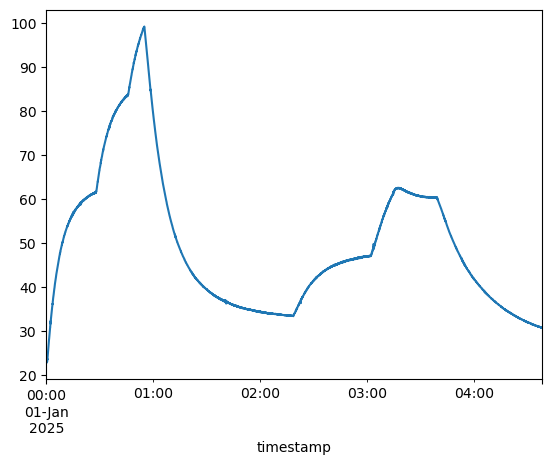

In [53]:
temp = df_id4['pm']
temp.plot()

In [54]:
def df_to_X_y(df_id4, window_size = 5):
    df_as_np = df_id4.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [[a] for a in df_as_np[i : i+5]]
        X.append(row)
        label = df_as_np[i+5]
        y.append(label)
    return np.array(X), np.array(y)

In [55]:
WINDOW_SIZE = 5
X, y = df_to_X_y(temp, WINDOW_SIZE)
X.shape, y.shape

((8351, 5, 1), (8351,))

In [56]:
X_train, y_train = X, y

In [57]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5,1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [58]:
cp = ModelCheckpoint('model1/', save_best_only = True)
model1.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate = 0.001), metrics = [RootMeanSquaredError()])

In [59]:
model1.fit(X_train, y_train, epochs = 10, callbacks = [cp])

Epoch 1/10
261/261 [==============================] - 3s 3ms/step - loss: 1525.8933 - root_mean_squared_error: 39.0627
Epoch 2/10
261/261 [==============================] - 1s 2ms/step - loss: 173.6145 - root_mean_squared_error: 13.1763
Epoch 3/10
261/261 [==============================] - 1s 2ms/step - loss: 31.9937 - root_mean_squared_error: 5.6563
Epoch 4/10
261/261 [==============================] - 1s 2ms/step - loss: 7.8867 - root_mean_squared_error: 2.8083
Epoch 5/10
261/261 [==============================] - 1s 2ms/step - loss: 2.5916 - root_mean_squared_error: 1.6098
Epoch 6/10
261/261 [==============================] - 1s 3ms/step - loss: 0.9688 - root_mean_squared_error: 0.9843
Epoch 7/10
261/261 [==============================] - 1s 3ms/step - loss: 0.4142 - root_mean_squared_error: 0.6436
Epoch 8/10
261/261 [==============================] - 1s 3ms/step - loss: 0.2018 - root_mean_squared_error: 0.4492
Epoch 9/10
261/261 [==============================] - 1s 3ms/step - loss

In [62]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data = {'Train Predictions': train_predictions, 'Actuals': y_train})
train_results

261/261 [==============================] - 1s 1ms/step


,Train Predictions,Actuals
0,22.912491,22.981836
1,22.923225,22.943714
2,22.910805,22.957186
3,22.915051,22.932407
4,22.905020,22.932966
...,...,...
8346,30.941196,30.853392
8347,30.949314,30.816502
8348,30.926456,30.813011
8349,30.926144,30.805555


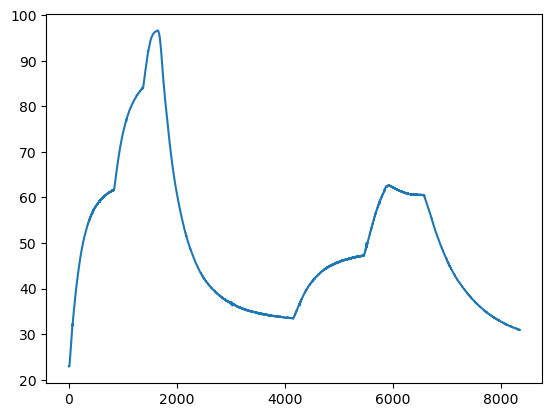

In [66]:
plt.plot(train_results['Train Predictions'])

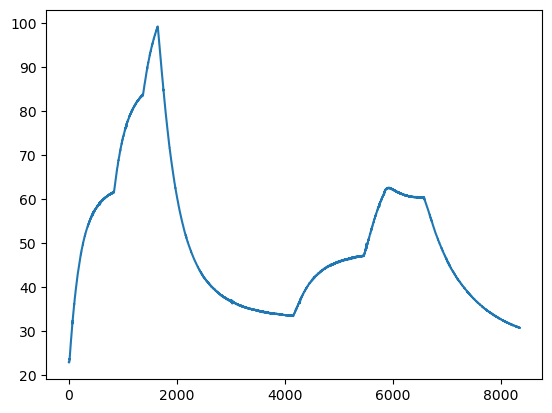

In [67]:
plt.plot(train_results['Actuals'])

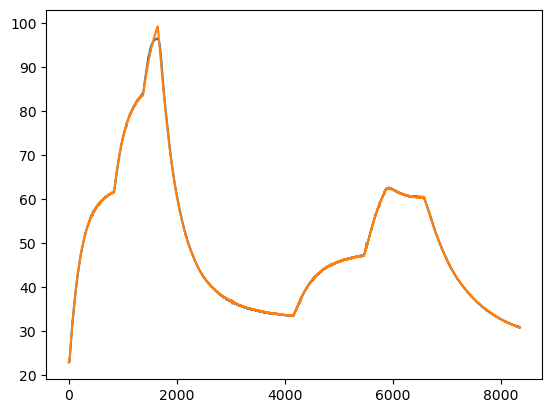

In [68]:
plt.plot(train_results['Train Predictions'])
plt.plot(train_results['Actuals'])

The neural network has learnt the patterns very clearly